In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import BatchSampler, RandomSampler
from sklearn.model_selection import KFold, GroupKFold

In [3]:
from lared_laughter.fusion.dataset import (
    FatherDataset, 
    FatherDatasetSubset, 
    CacheExtractor, 
    SegMaskExtractor)
from lared_laughter.accel.dataset import AccelExtractor
from lared_laughter.audio.dataset import AudioLaughterExtractor
from lared_laughter.video.dataset import VideoExtractor
from lared_laughter.video.dataset.transforms import get_kinetics_val_transform
from lared_laughter.constants import annot_exp_path, datasets_path
from lared_laughter.utils import get_metrics, load_examples
from lared_laughter.audio.models.resnet import get_pretrained_body as get_audio_feature_extractor
from lared_laughter.video.models.models import make_slow_pretrained_body as get_video_feature_extractor
from lared_laughter.utils import ious, plot_accel, plot_audio

In [4]:
examples = load_examples(os.path.join(annot_exp_path, 'processed', 'examples_without_calibration.csv'))

In [5]:
accel_ds_path = os.path.join(datasets_path, 'loose', 'accel_long.pkl')
videos_path = os.path.join(datasets_path, 'loose', 'video')
audios_path = os.path.join(datasets_path, "loose", "lared_audios.pkl")
annot_path = os.path.join(annot_exp_path, 'processed', 'continuous_corrected.pkl')
        
extractors = {
    'accel': AccelExtractor(accel_ds_path, min_len=1.5, max_len=1.5),
    'video': VideoExtractor(videos_path, transform=get_kinetics_val_transform(8, 256, False)),
    'audio':  AudioLaughterExtractor(audios_path, min_len=1.5, max_len=1.5)
}

def collate_fn(batch):
    batch = batch[0]
    return {k: torch.tensor(v) for k,v in batch.items()}

ds = FatherDataset(examples, extractors, 
    label_extractor=SegMaskExtractor(annot_path, min_len=1.5, max_len=1.5),
    id_column='hash')
train_ds = FatherDatasetSubset(ds, range(1,100), eval=False)
eval_ds  = FatherDatasetSubset(ds, range(1,100), eval=True)

g = torch.Generator()
g.manual_seed(22)
loader = DataLoader(
    dataset=train_ds,
    # This line below!
    sampler=BatchSampler(
        RandomSampler(train_ds, generator=g), batch_size=5, drop_last=False
    ),
    num_workers=0,
    generator=g,
    collate_fn=collate_fn
)


## Plot data from extractors

In [6]:
# batch = next(iter(loader))

In [52]:
sample = ds[22]

In [54]:
sample['label'].shape

(45,)

(('1_3043daaa2251d5bb838d07f549ac19b7d41fb1880bca6ab36da5bb0920851459', '19fd2fd064e6dffda57d9c721a5f3fa683c117cd6e9d9140a7c24d284e11b1d4', 'audio'), 2.9652872767361425, 4.4652872767361425)
(('1_3043daaa2251d5bb838d07f549ac19b7d41fb1880bca6ab36da5bb0920851459', '19fd2fd064e6dffda57d9c721a5f3fa683c117cd6e9d9140a7c24d284e11b1d4', 'audio'), 2.2310083167261823, 3.7310083167261823)


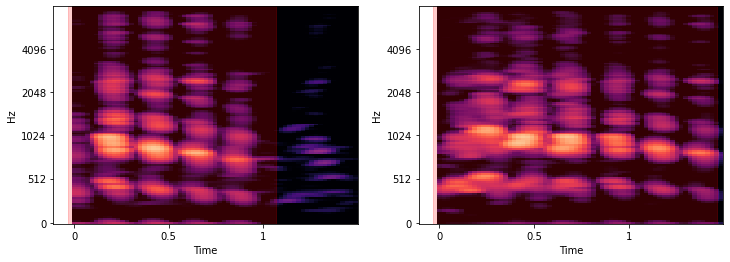

In [51]:
plot_audio([ds[332], ds[332]])